<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/Oscar/Big_Data_Milk_Oscar_NoStrings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Big Data Groupwork Milk


In [1]:
## To download and update the necessary requirements initialize Apache Spark, run this cell
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
sp = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Added our own necessary imports 
import seaborn as sns

from pyspark import SparkFiles

import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')
plt.rcParams['figure.figsize'] = [30, 20]

from pyspark.sql import types, Window
from pyspark.sql import functions as psf
from pyspark.sql.functions import col, unix_timestamp, to_date
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator

from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression, LinearRegressionModel

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import sys


# Mounting drive
from google.colab import drive, files
#drive.mount('/content/gdrive/')

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/mai

Loading the data into a DF


In [2]:
## Loading the data

fileName = 'ff_dairy_v1.csv'
if not os.path.isfile(fileName):
  uploaded = files.upload()

# Prepare and load the file into a spark rdd
spark.sparkContext.addFile(fileName)
milk_rdd = spark.read.csv(SparkFiles.get(fileName), header=True)
milk_rdd = milk_rdd.repartitionByRange("Cow number")
print("Number of partitions: ", milk_rdd.rdd.getNumPartitions())

Saving ff_dairy_v1.csv to ff_dairy_v1.csv
Number of partitions:  101


In [3]:
# To check spark rdd, uncomment the following line:
#milk_rdd.show(5)



---


## Creating a Machine Learning Model

### Data Preparation

In [5]:
## Renaming the columns with the unusable characters

newColumnNames = list(map(lambda x: x.replace(".","").replace("�C","degC").replace("�I","plusI"), milk_rdd.columns))

milk_rdd2 = milk_rdd.toDF(*newColumnNames)

In [6]:
## Fixing the RDD columns datatypes

# We need to change the datatype of each column in the rdd, to be able to
# process it correctly.

# Creating a function to set the given columns to the given datatype.
def fixType(datasetName, colName, dataType):
  """Takes a dataset and returns the dataset with the given column set to the given dataype"""
  return datasetName.withColumn(colName, psf.col(colName).cast(dataType))

# Preparing Lists with the column names according to which type they need to be.
allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)']
intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']


# Setting the columns to the correct type
for colName in doubleColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "double")
for colName in intColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "int")
#milk_rdd2 = milk_rdd2.withColumn("Date", psf.col("Date").cast("date"))
milk_rdd2 = milk_rdd2.withColumn("Date", to_date(unix_timestamp(col('Date'), 'dd/MM/yy').cast("timestamp")))

# Uncomment the next line to check the schema
#milk_rdd2.printSchema()


In [7]:
## Create the vectorizer that adds the features column needed to run the machine learning pipeline

### To change on which columns the LR model is build you only need to change ###
### the 2 variables: inputColNames and labelColName ###

# Columns that should not be in the linear regression model
doNotInput = ['Cow number', 'Date', 'Barn', 'Barn part']

# Columns used as input for the LR model. Previously used are comented for ease of testing.
#inputColNames = ['Protein preperiod (kg)','Crude fat (g/kg dm)','Protein%','Protein% preperiod','Fat%','Fat% preperiod']
#inputColNames = ['Water intake (kg)','Fat%', 'Protein%', 'Lactose%','Urea (mg/kg)', 'SCC (*1000/ml)']
#inputColNames = doubleColumns[0:10]
#inputColNames = intColumns
inputColNames = doubleColumns + intColumns
#inputColNames = [x for x in allColumns if x not in doNotInput]
inputColNames = ['Fat% preperiod', 'Manure consistency (1=fluid, 5= hard)', 'TPK (g/kg dm)','Lactose%','K (g/kg dm)','plusI (/kg dm)','Fat preperiod (kg)','Fat%','Avg pH','Protein% preperiod','Urin-pH','Manure fibre score (1=short, 5 = long)','Protein%','Protein preperiod (kg)']



print(inputColNames)

# The name of the column which value you want to predict.
labelColName = "Milk yield (kg)"

# Generating the name column which will be filled with the predicted values.
predictionColName = "Predicted " + labelColName

# Removing the label column from the input column if it ended in there on accident
if labelColName in inputColNames: inputColNames.remove(labelColName)


['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)',

In [9]:
# Forward fill blank values
milk_data = milk_rdd2
# define the window
window = Window.partitionBy('Cow number').orderBy('Day number').rowsBetween(-sys.maxsize, 0)

for column in milk_data.columns:
  # define the forward-filled column
  filled_column = psf.last(milk_data[column], ignorenulls=True).over(window)

  # do the fill 
  milk_data = milk_data.withColumn(column,  filled_column)

In [10]:
# Drop empty values (otherwise the pipeline can't work with the data)
milk_rdd3 = milk_data.dropna(how='any', subset=inputColNames+[labelColName])






#milk_rdd3.show(5)

# Uncomment the next line if you don't want to dropNA
#milk_rdd3 = milk_data 


In [11]:
## Assembling the vectorizer
vectorizer = VectorAssembler(
    inputCols=inputColNames, 
    outputCol="features")

In [12]:
## Splitting the dataset into a training and testing portion.

# Setting a seed for reproducible results.
ourSeed = 1234  # default = 1234

# Randomly splitting the dataset (default 20% test, 80% train)
(testSetDF, trainingSetDF) = milk_rdd3.randomSplit([2.0,8.0],seed=ourSeed)

# Uncomment to cache these datasets for performance
testSetDF.cache()
trainingSetDF.cache()

trainingSetDF.show(5)

+----------+----------+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+------+----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+----

### Linear Regression Machine Learning Model

In [13]:
## Training a linear regression model with the default settings.

# Initialize the linear regression learner with default values for the parameters
lr = LinearRegression()

# Setting the name of the column with the values that need to be learned
# and setting the name of the column where the predicted results will be saved.
lr.setLabelCol(labelColName)\
  .setPredictionCol(predictionColName)

# Create a pipeline that performs the vectorizer and the Linear Regression
# learning model.
lrPipeline = Pipeline(stages = [vectorizer] + [lr])

# Uncomment the next line to show if the training set was created correctly
#trainingSetDF.show(5)

# Train the model on the training set with the default settings.
lrModel = lrPipeline.fit(trainingSetDF)


In [14]:
## Inspecting the results of the previous model

# The coefficients (i.e., weights) are as follows:
weights = lrModel.stages[1].coefficients

# The corresponding features for these weights are:
featuresNoLabel = vectorizer.getInputCols()

# Print coefficients 
weightsList = list(zip(featuresNoLabel, weights))
print(weightsList)
 
 # Print the intercept
print("Intercept: ",lrModel.stages[1].intercept)

['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (

In [15]:
# Function that sorts a list of sublists on the second element of the sublist 
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1]) 
    return sub_li 
  
# Use the Sort function
print(Sort(weightsList)) 

[('Fat% preperiod', -20.92186675502615), ('Manure consistency (1=fluid, 5= hard)', -5.616592042124714), ('TPK (g/kg dm)', -2.7351600816912534), ('Lactose%', -2.359683768549604), ('K (g/kg dm)', -2.232031400318826), ('plusI (/kg dm)', -2.0205397312434075), ('Fat preperiod (kg)', -2.0091229841906033), ('SPK (g/kg dm)', -1.8537679302613375), ('WDE (g/kg dm)', -1.8483486151520487), ('WDS (g/kg dm)', -1.4902371226776683), ('Barn part', -1.1821369484055453), ('TPE (g/kg dm)', -1.1230960186881978), ('MELK (/kg dm)', -0.9060908317286787), ('nXP (g/kg dm)', -0.7586099876099558), ('Lactation number', -0.6196414365261101), ('Ca (g/kg dm)', -0.6029358225032555), ('Cl (g/kg dm)', -0.5574053829980127), ('BCS', -0.5279664990692788), ('Crude fiber (g/kg dm)', -0.5249395157566743), ('Backfat Thickness', -0.37707506867457774), ('WI (/kg dm)', -0.33839913942237115), ('Intake total ration (kg dm)', -0.2904767199833305), ('Day number', -0.18384248848837034), ('Concentrate intake (kg)', -0.16036806970498027

In [17]:
## Model Predictions:

 # Apply our LR model to the test data and predict power output
predictionsLR = lrModel.transform(testSetDF).select(inputColNames+[labelColName]+[predictionColName])

 # Print the first 15 rows of your predictions
predictionsLR.show(15)

#Plotting predicted against actual values to show linearity
#sns.scatterplot(x=labelColName, y=predictionColName, data=predictionsLR.toPandas(),size=10)

+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+----+--------+--------+----------------------+---------+----------------------+------+----------------------+---------------+-----------------+-------------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+----------+----+---------+----------------+------------+----------+----+-----------------+------------+--------------+-------------------------+-------------------------------------+--------------------------------------+-------------------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+-----------+-----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------

In [18]:
## Compute an evaluation metric for our test dataset

# Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol=predictionColName, labelCol=labelColName, metricName="rmse")

# Run the evaluator on the DataFrame
rmse = regEval.evaluate(predictionsLR)

# Print the Root Mean Squared Error
print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 3.91


In [19]:
## Compute R-squared evaluation metric for our test dataset

r2 = regEval.evaluate(predictionsLR, {regEval.metricName: "r2"})

# Print R-squard
print("r2: {0:.2f}".format(r2))

r2: 0.39


### Parameter Tuning and Evaluation

In [20]:
## Use paramater tuning to try to create a better linear regression model

# We can reuse the RegressionEvaluator, regEval, to judge the model based on the best Root Mean Squared Error
# Let's create our CrossValidator with 3 fold cross validation
crossval = CrossValidator(estimator=lrPipeline, evaluator=regEval, numFolds=3)

# Tune over our regularization parameter from 0.01 to 0.10
regParam = [x / 100.0 for x in range(1, 11)]

# Create a paramter grid using the ParamGridBuilder,
# and add the grid to the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regParam)
             .build())
crossval.setEstimatorParamMaps(paramGrid)

# Find and return the best model
cvModel = crossval.fit(trainingSetDF).bestModel

In [21]:
## Evaluate the new tuned model by comparing it to the default linear regression

# Use cvModel to compute an evaluation metric for our test dataset: testSetDF
predictionsRL = cvModel.transform(testSetDF).select(inputColNames+[labelColName]+[predictionColName])

# Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseLR = regEval.evaluate(predictionsRL)

# Compute the r2 evaluation metric for our test dataset
r2LR = regEval.evaluate(predictionsRL, {regEval.metricName: "r2"})

# Printing the rounded values to compare the 2 linear regression models.
print("Original Root Mean Squared Error: {0:2.2f}".format(rmse))
print("New Root Mean Squared Error: {0:2.2f}".format(rmseLR))
print("Old r2: {0:2.2f}".format(r2))
print("New r2: {0:2.2f}".format(r2LR))

# Printing unrounded values for better testing purpose
print("\r\n","Un-rouned values printed above in same order:\r\n",rmse,rmseLR,r2,r2LR)

Original Root Mean Squared Error: 3.91
New Root Mean Squared Error: 3.62
Old r2: 0.39
New r2: 0.47

 Un-rouned values printed above in same order:
 3.9066745343312097 3.6173753888673925 0.3867549446222691 0.47421674466987285


# Visualization

## Plotting sample of dataset against 1 column

In [22]:
## Copy of setting the correct columns to allow easier plotting

### CHANGE inputColNames (list of x) AND LabelColName (y) TO CREATE THE
### DESIRED PLOTS. # ONLY 10 x VALUES CAN BE ENTERED AT A TIME

inputColNames = ['Protein preperiod (kg)','Fat preperiod (kg)','Crude fat (g/kg dm)','Protein%','Protein% preperiod','Fat%','Fat% preperiod']
#inputColNames = doubleColumns[0:10]

labelColName = "Milk yield (kg)"
predictionColName = "Predicted " + labelColName

# Removing the label column from the input column if it ended in there on accident
if labelColName in inputColNames: inputColNames.remove(labelColName)

#milk_rdd3 = milk_rdd2.dropna(how='any', subset=inputColNames+[labelColName])
milk_rdd3 = milk_rdd2.select(inputColNames+[labelColName])

<Figure size 720x720 with 0 Axes>

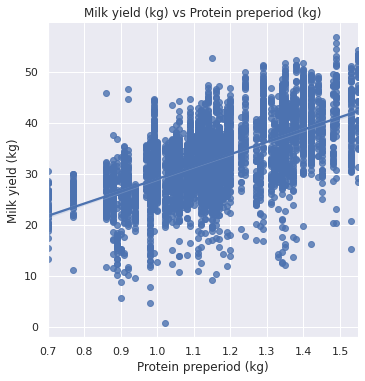

<Figure size 720x720 with 0 Axes>

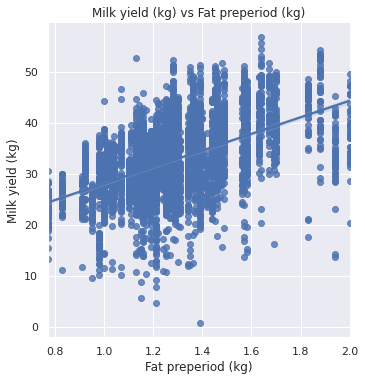

<Figure size 720x720 with 0 Axes>

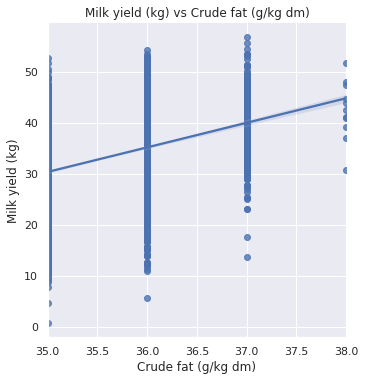

<Figure size 720x720 with 0 Axes>

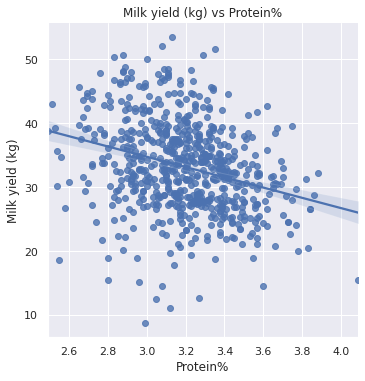

<Figure size 720x720 with 0 Axes>

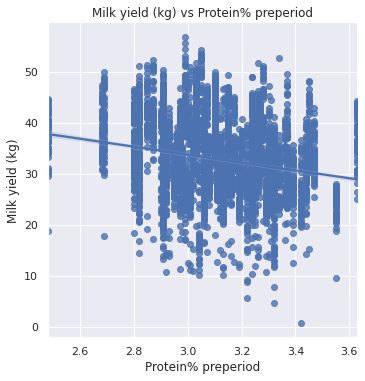

<Figure size 720x720 with 0 Axes>

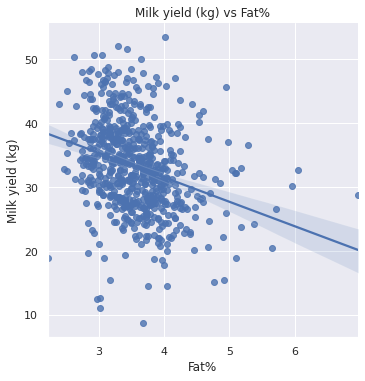

<Figure size 720x720 with 0 Axes>

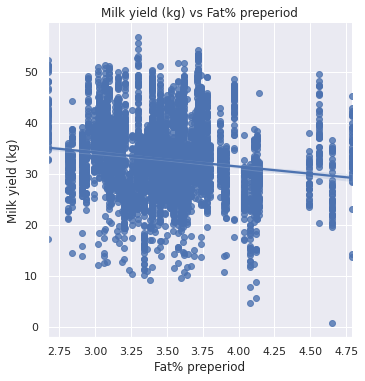

In [23]:
## Plotting the columns versus the labelcolumn to get inital idea of linear regression

### Trying to plot more than 10 plots at the same time results in empty plots ###

milk_rdd3_sample = milk_rdd3.select(inputColNames+[labelColName]).sample(False,0.5)
#print(milk_rdd3_sample)
sns.set(rc={'figure.figsize':(10,10)})

for column in inputColNames:
  plt.figure()
  sns.lmplot(x=column, y=labelColName,data=milk_rdd3_sample.toPandas())
  plt.title(labelColName+" vs "+column)
  plt.xlabel(column)
  plt.ylabel(labelColName)

In [ ]:
milk_rdd2.show(5)
milk_rdd2_sample = milk_rdd2.sample(False,0.1)

In [ ]:
sns.lmplot(x="Day number", y="Milk yield (kg)", hue="Treatment", data=milk_rdd2_sample.toPandas(),height=10);

sns.lmplot(x="Day number", y="Milk yield (kg)", hue="Treatment", data=milk_rdd2_sample.filter(psf.col("Period (VP = preperiod, HP = trial period)")=="HP").toPandas(),height=10);
